<center>
<h3>Universidade Federal do Rio Grande do Sul (UFRGS)<br>
Programa de Pós-Graduação em Engenharia Civil (PPGEC)<br>
PEC00144 - Métodos Experimentais em Engenharia Civil</h3>

<h1>Trabalho Final</h1>

<h3>Aluno: Eduarto Pagnussat Titello</h3>

</center>

Este trabalho consiste em projetar, construir e instrumentar um modelo reduzido. A estrutura adotada é uma torre de 3 pavimentos/níveis, representada por um *shear building*, e tem-se como objetivo a determinação da frequência fundamental de vibração da estrutura real a partir do modelo reduzido. 

\tableofcontents

\pagebreak


In [1]:
# Importando e configurando módulos
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import jupyter2latex as j2l
import scipy.linalg
import scipy.stats as st
from MRPy import MRPy
import serial
import time

# Apresentação da estrutura real

A estrutura a ser representada pelo modelo é uma torre de planta quadrada, formada por um pilar em cada extremidade e construída em concreto C25. Essa e suas dimensões são apresentadas a seguir:

![Estrutura](./images/estruturaP.png)

Adotando concreto da classe C25 tem-se $E_C=28GPa$, transcrevendo as propriedades da estrutura real tem-se:

In [2]:
# Dados da geometria
est_L  = 5.0            # Distância entre pisos
est_Pn = 4              # Pilares por pavimento
est_Pb = 0.25           # Largura dos pilares
est_Vn = 4              # Vigas por pavimento
est_Vb = 0.20           # Largura das vigas
est_Vh = 0.40           # Altura das vigas
est_LP = 4.00           # Lado dos pavimentos
est_Lh = 0.10           # Altura das lajes 
est_cg = 335            # Carga nas lajes/m²

# Rigidez EI
est_I = est_Pb**4/12    # Inércia do pilar
est_E = 28E9            # E do concreto
est_EI = est_I*est_E    # EI do pilar

# Projeto do modelo reduzido

O projeto do modelo reduzido é baseado na introdução de escalas que relacionem as grandezas do modelo reduzido e do modelo real, onde o número de escalas deve ser menor ou igual ao número de grandezas fundamentais envolvidas no problema. Para o problema em questão as grandezas fundamentais são três: comprimento ($L$), massa ($M$) e tempo ($T$), que formam a base da matriz dimensional. Para construção do modelo reduzido as grandezas escolhidas para serem escaladas são relativas ao comprimento ($L$), à rigidez à flexão ($EI$) e à aceleração ($a$).

Os fatores de escala adotados para $L$ e $EI$ são baseados no material empregado para construção das colunas do modelo, essas são formadas por réguas de alumínio, com $52.5 cm$ de comprimento, $2.58 cm$ de largura e $0.10 cm$ de espessura, dimensões obtidas com auxílio de um paquimetro. As réguas utilizadas são apresentadas na figura a seguir:

![Réguas](./images/reguas.png)

In [3]:
mod_b = 0.0258
mod_h = 0.0010
mod_E = 70E9

Descontando um trecho para realização do engaste e dividindo o comprimento restante da régua em 3 partes iguais, a distância entre os pavimentos é representada por trechos de $16.5 cm$, logo, a escala de comprimento $\lambda_L$ é:

In [4]:
mod_L = 0.165
scale_L = mod_L/est_L

j2l.print(f"Escala de comprimentos: $ \lambda_L = 1:{1/scale_L:.2f} $.")

Escala de comprimentos: $ \lambda_L = 1:30.30 $.

A escala da rigidez à flexão $EI$ relaciona a rigidez das 2 réguas à das 4 colunas da torre. Assumindo para as réguas $E_{Al}=70 GPa$, a rigidez $EI$ das réguas e a escala de rigidez são dadas por:

In [5]:

mod_I = mod_b * mod_h**3 / 12
mod_EI = mod_E*mod_I
scale_EI = (2*mod_EI)/(est_Pn*est_EI)

j2l.print('''- Momento de inércia de uma régua: $I={mod_I:.3E} \: m^4$

- Rigidez à flexão de uma régua: $EI = {mod_EI:.3E} Nm^2$

- Escala de rigidez: $\lambda_{EI}=1:{scale_EI:.3E} $
'''.format(mod_I=mod_I, mod_EI=mod_EI, EI='{EI}', scale_EI=1/scale_EI))


- Momento de inércia de uma régua: $I=2.150E-12 \: m^4$

- Rigidez à flexão de uma régua: $EI = 1.505E-01 Nm^2$

- Escala de rigidez: $\lambda_{EI}=1:1.211E+08 $

Em relação à escala de acelerações ($a$) optou-se por manter a proporção $\lambda_a=1:1$. Todavia, visto que o problema de vibração livre é independente da aceleração da gravidade essa poderia ser alterada.

In [6]:
scale_a = 1/1

Em posse das escalas impostas, para construção do modelo reduzido e realização da análise devem ser conhecidas as escalas derivadas necessárias, que são obtidas através de uma análise dimensional, onde a base da nova matriz dimensional será formada pelas grandezas $L$, $EI$ e $a$. Fazendo uso da metodologia implementada por Rocha (2021), a base da matriz dimensional é alterada para a base $L$, $EI$ e $a$:

In [7]:
# Importando DimData 
DimData = pd.read_excel('../Resources/DimData.xlsx', index_col=0, sheet_name='DimData')

# Grandezas fundamentais originais 
LMT = ['L', 'M', 'T']

# Novas base de grandezas
ABC = ['L', 'EI', 'a'] 

# Importa matriz dimensional de ABC na base LMT
base = DimData.loc[ABC, LMT]
j2l.df2table(base, '{} na base {}'.format(','.join(ABC), ','.join(LMT)))

# Inverte base de unidades de LMT para ABC
base_i = pd.DataFrame(np.linalg.inv(base), index=LMT, columns=ABC)
j2l.df2table(base_i, '{} na base {}'.format(','.join(LMT), ','.join(ABC)))

,L,M,T
L,1,0,0
EI,3,1,-2
a,1,0,-2


,L,EI,a
L,1.0,0.0,0.0
M,-2.0,1.0,-1.0
T,0.5,-0.0,-0.5


Para análise do modelo reduzido é necessário o conhecimento da escala de massa ($\lambda_m$), necessária para determinação das massas dos pavimentos, e a escala de frequências ($\lambda_f$), que relaciona as frequências de vibração do modelo reduzido e da estrutura real. Para a determinação de tais fatores essas grandezas devem estar presentes na matriz dimensional de base $L$, $EI$ e $a$.

In [8]:
par = ABC + ['m', 'f']
npar = len(par)

DMat_LMT = DimData.loc[par, LMT]
DMat_ABC = np.matmul(DMat_LMT, base_i)
DMat_ABC.rename(columns=dict(zip(LMT, ABC)), inplace=True) # Renomeia colunas para nova base
j2l.df2table(DMat_ABC, 'Matriz $D$  na base {}'.format(','.join(ABC)))

,L,EI,a
L,1.0,0.0,0.0
EI,0.0,1.0,0.0
a,0.0,0.0,1.0
m,-2.0,1.0,-1.0
f,-0.5,0.0,0.5


Por fim, aplicando sobre a matriz $\bf{D}$ as escalas impostas tem-se a tabela de escalas:

In [9]:
escalas = np.array([scale_L, scale_EI, scale_a])
escalas = np.tile(escalas, (npar, 1))
escalas = np.prod(escalas**DMat_ABC, axis=1)
escalas = pd.DataFrame({'λ': escalas, '1/λ': 1/escalas}, index=par)
j2l.df2table(escalas, 'Fatores de escala')

j2l.print("""Escalas derivadas:

- Escala de massa: $\lambda_m = 1:{:.2E}$

- Escala de frequências: $\lambda_f = {:.3f}:1$""".format(escalas.loc['m', '1/λ'], escalas.loc['f', 'λ']))

,λ,1/λ
L,3.300000e-02,3.030303e+01
EI,8.256000e-09,1.211240e+08
a,1.000000e+00,1.000000e+00
m,7.581267e-06,1.319041e+05
f,5.504819e+00,1.816590e-01


Escalas derivadas:

- Escala de massa: $\lambda_m = 1:1.32E+05$

- Escala de frequências: $\lambda_f = 5.505:1$

Para determinação da massa que os pavimentos do modelo reduzido devem possuir, a massa da estrutura real é cálculada e escalada por $\lambda_m$:

In [10]:
M_vigas   = est_Vb*est_Vh * est_LP * est_Vn * 2500 
M_laje    = est_Lh * est_LP**2 * 2500         
M_cargas  = est_cg * est_LP**2                
M_pilares = est_Pb**2 * est_L * est_Pn * 2500

M_pavtipo = M_vigas + M_laje + M_cargas + M_pilares
M_pavcob  = M_vigas + M_laje + M_cargas + M_pilares/2

j2l.print("""Massas da estrutura:

- Massa dos pavimentos tipo: {:.1f} kg

- Massa do pavimento de cobertura {:.1f} kg""".format(M_pavtipo, M_pavcob))

Massas da estrutura:

- Massa dos pavimentos tipo: 15685.0 kg

- Massa do pavimento de cobertura 14122.5 kg

Logo as massas dos pavimentos do modelo em escala deverão ser:

In [11]:
mod_m23 = M_pavtipo*escalas.loc['m', 'λ']
mod_m1  = M_pavcob*escalas.loc['m', 'λ']

j2l.print("""
Massas do modelo em escala:

- Massa dos pavimentos tipo: {:.3f} kg

- Massa do pavimento de cobertura {:.3f} kg""".format(mod_m23, mod_m1))

Massas do modelo em escala:

- Massa dos pavimentos tipo: 0.119 kg

- Massa do pavimento de cobertura 0.107 kg

# Construção do modelo 

Para construção do modelo são utilizados, além das réguas, perfis cantoneira de aluminínio, com lado $3.20 cm$ e espessura $0.18 cm$, fita isolante, presilhas de papel e alguns metais para obtenção da massa cálculada. Pedaços do perfil cantoneira são utilizados para fixação da régua na base, formando um engaste de $\approx 3cm$. O modelo construído é apresentado na figura a seguir:

![Modelo construído](./images/colagem.png)

Para determinação da massa dos pavimentos, a massa das duas réguas ($2\times37g$) é dividida pelos seus tamanhos ($52.5cm$), obtendo uma massa linear de $1.41 g/cm$. Essa massa linear é aplicada sobre cada pavimento considerando que a massa dos pilares é dividida entre os pavimentos superiores e inferiores, dessa forma, a massa relativa às réguas aplicada sobre o pavimento da cobertura considera o comprimento de meio desnível ($8.25cm, ~12g$), enquanto nos demais pavimentos é considerado o desnível completo ($16.5cm, ~23g$). 

A massa projetada para cada pavimento foi obtida posicionando sobre a balança a base do modelo com apenas as colunas instaladas. Conhecida a massa do modelo foi fixada a estrutura do pavimento seguinte e sua massa obtida pela diferença de massas. Esse processo foi adotado pois a balança utilizada não apresentou boa precisão para massas muito pequenas, e também pelo fato do cabo de conexão do acelerômetro estar conectado à uma mesa acima do modelo. 

A massa média/aproximada dos elementos empregados no modelo são:

- $62g$ por pedaço de perfil cantoneira;

- $4g$ por presilha de papel; 

- Na cobertura: 

    - $6g$ do acelerômetro;

    - $12g$ relativos às régua;

    - $19g$ de massa adicional;
 
- Nos demais pavimentos: 

    - $23g$ relativos às régua;

    - $26g$ de massa adicional;


# Determinação teórica das frequências de vibração

As frequências na qual o modelo deve vibrar podem ser obtidas matematicamente, para isso as matrizes de rigidez e de massa do modelo devem ser conhecidas. Esse processo é implementado em uma função para que a propagação de erro seja posteriormente avaliada, dessa forma: 

In [12]:
def freqs(EI, L1, L2, L3, m1, m2, m3):
    k1 = 12*EI/L1**3
    k2 = 12*EI/L2**3
    k3 = 12*EI/L3**3
    K = np.array([
        [+2*k1, -2*k1,       0],
        [-2*k1, +2*k1+2*k2, -2*k2],
        [    0, -2*k2,      +2*k2+2*k3]])

    M = np.diag(np.array([m1, m2, m3]))
    w21, _ = scipy.linalg.eig(K, M)

    iw = w21.argsort()
    w21 = w21[iw]
    wk = np.sqrt(np.real(w21))
    fk = wk/(2*np.pi)

    return fk

In [13]:
fk = freqs(mod_EI, mod_L, mod_L, mod_L, mod_m1, mod_m23, mod_m23)
j2l.print("""Frequências naturais teóricas de vibração do modelo:

- $f_1 = {:.2f} Hz$

- $f_2 = {:.2f} Hz$

- $f_3 = {:.2f} Hz$""".format(*fk))

Frequências naturais teóricas de vibração do modelo:

- $f_1 = 5.99 Hz$

- $f_2 = 16.63 Hz$

- $f_3 = 23.73 Hz$

# Análise de propagação de erro

Diversas incertezas estão presentes na construção do modelo reduzido, como a massa dos pavimentos, a rigidez à flexão das réguas, o real coeficiente de engastamento das ligações e a distância entre os pisos. Tratando tais incertezas como variáveis aleatórias pode-se estimar o erro propagado por essas nas frequências naturais.

Empregando a distribuição normal para todas as variáveis aleatórias os paramêtros adotados são:

- Módulo de elasticidade $E$ do alumínio: $\mu_E = 70 GPa$ com $CV_E=0.05$, com CV baseado no valor adotado para o aço;

- Distâncias entre pavimentos $L1, L2, L3$ (3 variáveis diferentes): $\mu_L = 0.165 m$ com $\sigma_L = 0.01 m$, de forma a englobar possíveis problemas de posicionamento e tentar emular a flexibilidade dos engastes. 

- Massa do pavimento da cobertura $m1$: $\mu_{m1} = 0.107 kg$ com $\sigma_{m1} = 0.001 kg$, visto que a balança tem precisão de $1g$;

- Massa dos demais pavimentos $m2$ e $m3$: $\mu_{m2,3} = 0.119 kg$ com $\sigma_{m2,3} = 0.001 kg$.

A largura e a espessura das réguas foram medidas com auxílio de um paquimetro e não apresentaram divergências, dessa forma, são adotados para essas propriedades valores constantes. Cabe observar que a resolução do equipamento é $0.01mm$, de forma que o coeficiente de variação das variáveis seria $CV \le 0.01 $.

Dessa forma, através do método de simulação por Monte Carlo: 

In [14]:
def properro(Ns):
    # Variáveis aleatórias
    dist_E   = st.norm(mod_E,   mod_E*0.05)
    dist_L1  = st.norm(mod_L,   0.01)
    dist_L2  = st.norm(mod_L,   0.01)
    dist_L3  = st.norm(mod_L,   0.01)
    dist_m1  = st.norm(mod_m1,  0.001) 
    dist_m23 = st.norm(mod_m23, 0.001) 

    # fixa semente 
    np.random.seed(66681186)

    # Coloca tudo em um dataframe
    dados = pd.DataFrame()
    dados['EI']  = mod_I*dist_E.rvs(Ns)
    dados['L1']  = dist_L1.rvs(Ns)
    dados['L2']  = dist_L2.rvs(Ns)
    dados['L3']  = dist_L3.rvs(Ns)
    dados['m1']  = dist_m1.rvs(Ns)
    dados['m23'] = dist_m23.rvs(Ns)
    
    # Cálcula frequências e armazena no dataframe também 
    #dados['f1'], dados['f2'], dados['f3']
    res = np.array(list(map(freqs, dados['EI'].values, dados['L1'].values, dados['L2'].values, dados['L3'].values, dados['m1'].values, dados['m23'].values, dados['m23'].values)))

    dados['f1'], dados['f2'], dados['f3'] = res[:, 0], res[:, 1], res[:, 2]

    return dados

Realizando $100.000$ simulações tem-se:

In [15]:
sims = properro(100_000)

In [16]:
# Configura saída do pandas
pd.set_option('display.float_format', lambda x: f'{x:.3E}')
# Calcula CV
desc_geral = sims.describe().loc[['mean', 'std', 'min', 'max']].T
desc_geral['CV'] = desc_geral['std']/desc_geral['mean']
desc_geral = desc_geral.T
# Printa
j2l.df2table(desc_geral[['EI', 'L1', 'L2', 'L3', 'm1', 'm23']], 'Descrição geral dos dados de entrada','tab:descE')
j2l.df2table(desc_geral[['f1', 'f2', 'f3']], 'Descrição geral das frequências naturais', 'tab:descf')

,EI,L1,L2,L3,m1,m23
mean,1.505E-01,1.650E-01,1.650E-01,1.650E-01,1.071E-01,1.189E-01
std,7.510E-03,9.970E-03,9.982E-03,9.997E-03,1.001E-03,9.962E-04
min,1.157E-01,1.203E-01,1.227E-01,1.222E-01,1.028E-01,1.146E-01
max,1.804E-01,2.058E-01,2.090E-01,2.072E-01,1.113E-01,1.235E-01
CV,4.990E-02,6.043E-02,6.050E-02,6.059E-02,9.351E-03,8.377E-03


,f1,f2,f3
mean,5.980E+00,1.663E+01,2.406E+01
std,3.898E-01,1.060E+00,1.601E+00
min,4.546E+00,1.289E+01,1.843E+01
max,7.928E+00,2.210E+01,3.312E+01
CV,6.519E-02,6.371E-02,6.653E-02


Na tabela \ref{tab:descf} são apresentadas as propriedades estatísticas das variáveis aleatórias que representam as três frequências da estrutura. 

Comparando os dados simulados da primeira frequência à uma distribuição normal tem-se:

Text(0.5, 0, '$f_1$')

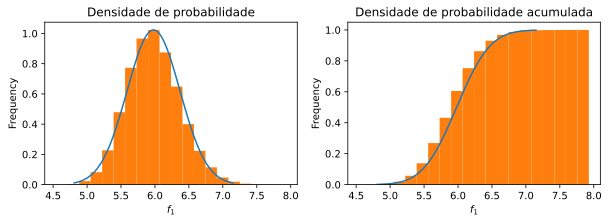

In [17]:
dist_f1 = st.norm(desc_geral['f1']['mean'], desc_geral['f1']['std'])
x = np.linspace(-3*desc_geral['f1']['std'] +   desc_geral['f1']['mean'], 
                   desc_geral['f1']['mean']+ 3*desc_geral['f1']['std'], 200)

plt.figure(num=0, figsize=(10,3))
# Hstograma simples
ax1 = plt.subplot(1,2,1)
ax1.set_title('Densidade de probabilidade')
ax1.plot(x, dist_f1.pdf(x))
sims['f1'].plot(kind='hist', density=True, bins=20)
ax1.set_xlabel('$f_1$')

# Hstograma acumulado
ax1 = plt.subplot(1,2,2)
ax1.set_title('Densidade de probabilidade acumulada')
ax1.plot(x, dist_f1.cdf(x))
sims['f1'].plot(kind='hist', density=True, bins=20, cumulative=True)
ax1.set_xlabel('$f_1$')

Logo a primeira frequência $f_1$ pode ser representada por uma distribuição normal.

# Instrumentação e análise do sinal

Para leitura e processamento das acelerações são utilizados um Arduino Uno, um acelerômetro MPU6050 e os códigos desenvolvidos por Rocha (2021), onde foram introduzidas pequenas alterações. Essencialmente os códigos são transformados em uma única função onde as acelerações são lidas, reescaladas, reamostradas (fixando o time step) e gravadas/lidas em um registro. Conforme:

In [18]:
def Acelr(nlines, arq=None, port='COM3', baud=115200):
    # Le arquivo antigo
    if nlines == 0:
        print(f'Lendo dados anteriores de `registros\\{arq}.xlsx`.')
        data = MRPy.from_file(f'registros\\{arq}', form='excel')
        return data
    
    #--------------
    # Inicia conexão
    Ardn  =  serial.Serial(port, baud, timeout=1)

    # Função que faz leitura 
    def ReadSerial(nchar, nvar, nlines):
        Ardn.write(str(nlines).encode())
        data = np.zeros((nlines,nvar))
        for k in range(nlines):
            wait = True
            while(wait):
                if (Ardn.inWaiting() >= nchar):
                    wait = False
                    bdat = Ardn.readline() 
                    sdat = bdat.decode()
                    sdat = sdat.replace('\n',' ').split()
                    data[k, :] = np.array(sdat[0:nvar], dtype='int')
        return data

    # Precisa deixar tipo 1 segundo para realizar conexão.
    # No caso aumentei o tempo para facilitar na hora da excitação. 
    # OBS: A luz TX do arduino acende quando a conexão está ligada!
    print("Wait for it...")
    time.sleep(4)
    print("Reading, go!")

    try:
        data = ReadSerial(30, 4, nlines)
        t    = data[:,0 ]
        acc  = data[:,1:]

        Ardn.close()
        print('Acquisition ok!')

        # Ajusta escala dos dados
        ti  = (t - t[0])/1000
        a   =  2*9.81*acc/2**15
        # Fixa tamaho do timestep 
        data = MRPy.resampling(ti, a)
        print('Average sampling rate is {0:5.1f}Hz.'.format(data.fs))

        if arq:
            # Salva dados
            print(f'Salvando dados em `registros\\{arq}.xlsx`.')
            data.to_file(f'registros\\{arq}', form='excel')

        # Entrega dados processados
        return data
        
    except:
        Ardn.close()
        sys.exit('Acquisition failure!')

Foram realizadas 3 medições excitando o primeiro modo e 1 excitando todos os modos, todas através de impulsos laterais.

Plotando no tempo as acelerações e o periodograma dos 3 eixos da primeira medição tem-se:

In [19]:
med = Acelr(0, arq="med11ok")

Lendo dados anteriores de `registros\med11ok.xlsx`.


[[<matplotlib.lines.Line2D at 0x28cf5c097f0>],

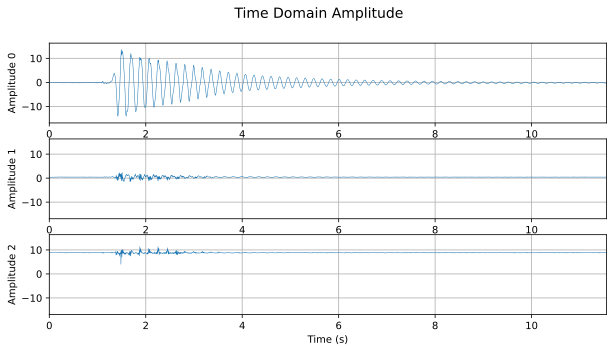

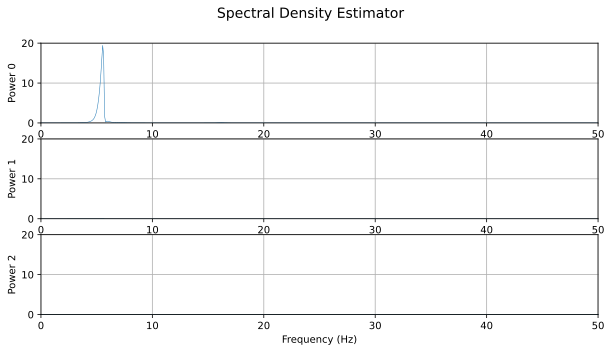

In [20]:
med11 = med.copy()
med11.plot_time(fig=1, figsize=(10,5))
med11.plot_freq(fig=2, figsize=(10,5), axis_f=(0,50,0,20))

Observa-se que foram medidas acelerações nos eixos Y e Z, todavia de pequenas intensidades e sem energia aparente na escala adotada, assim, para realização das análises dos resultados apenas o eixo X é empregado.

## Excitação do primeiro modo

Conforme determinado anteriormente, a frequência teórica de vibração do primeiro modo é $5.99 Hz$. Através da análise de propagação de erro foram ainda determinados para a primeira frequência $\mu_{f1}=5.98 Hz$ e $\sigma_{f1}=0.39 Hz$. 

Plotando as 3 medições de aceleração pelo tempo tem-se:

In [21]:
med = Acelr(0, arq="med11ok")
med11 = MRPy(med[0], Td=med.Td)

med = Acelr(0, arq="med12ok")
med12 = MRPy(med[0], Td=med.Td)

med = Acelr(0, arq="med13ok")
med13 = MRPy(med[0], Td=med.Td)

Lendo dados anteriores de `registros\med11ok.xlsx`.
Lendo dados anteriores de `registros\med12ok.xlsx`.
Lendo dados anteriores de `registros\med13ok.xlsx`.


[[<matplotlib.lines.Line2D at 0x28cf5cc9130>]]

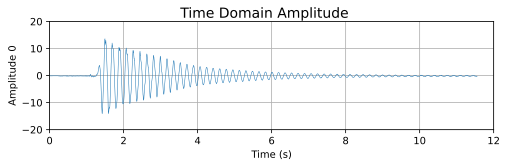

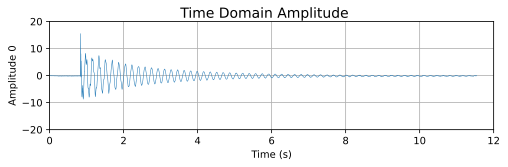

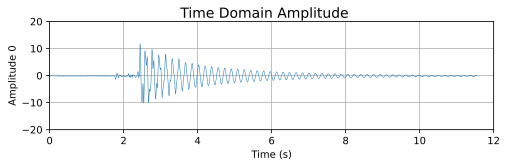

In [22]:
med11.plot_time(fig=3, figsize=(8,2), axis_t=[0,12,-20,20])
med12.plot_time(fig=4, figsize=(8,2), axis_t=[0,12,-20,20])
med13.plot_time(fig=5, figsize=(8,2), axis_t=[0,12,-20,20])

Enquanto plotando os periodogramas tem-se:

[[<matplotlib.lines.Line2D at 0x28cf5d6d0d0>]]

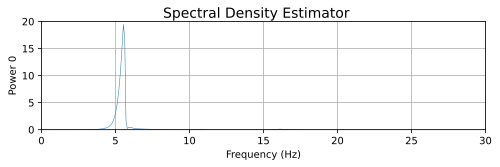

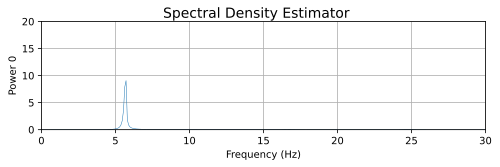

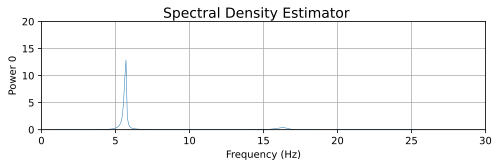

In [23]:
med11.plot_freq(fig=3, figsize=(8,2), axis_f=[0,30,0,20])
med12.plot_freq(fig=4, figsize=(8,2), axis_f=[0,30,0,20])
med13.plot_freq(fig=5, figsize=(8,2), axis_f=[0,30,0,20])

Ampliando na região do pico de energia tem-se:

[[<matplotlib.lines.Line2D at 0x28cf5f39c10>]]

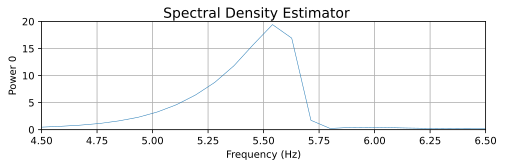

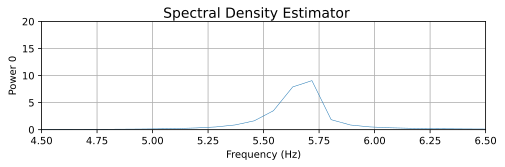

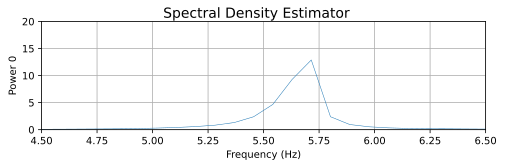

In [24]:
med11.plot_freq(fig=3, figsize=(8,2), axis_f=[4.5,6.5,0,20])
med12.plot_freq(fig=4, figsize=(8,2), axis_f=[4.5,6.5,0,20])
med13.plot_freq(fig=5, figsize=(8,2), axis_f=[4.5,6.5,0,20])

Pela primeira medição, de maior energia, o pico é observado na frequência de $5.6 Hz$, enquanto nas demais esse está em aproximadamente $5.7 Hz$. Em todos os casos é ainda observado um intervalo de frequências atuantes, que cresce com o aumento da energia atuante no modo. Comparando os valores observados aos estimados pela propagação de erro esses estão cerca de $1\times\sigma$ e $0.7\times\sigma$ abaixo do valor esperado. 

Adotando como frequência fundamental do modelo $5.7 Hz$ e aplicando sobre esse o fator de escala de frequências $\lambda_f$ tem-se:

In [25]:
j2l.print("Frequência fundamental da estrutura obtida a partir do modelo reduzido: $$f_1 = {:.2f} Hz$$".format(5.7/escalas.loc['f', 'λ']))

Frequência fundamental da estrutura obtida a partir do modelo reduzido: $$f_1 = 1.04 Hz$$

## Excitação de todos os modos

Por tratar-se de um *shear building* de 3 pavimentos a estrutura apresenta 3 frequências teoricas de vibração. Através de um impulso próximo à base foram excitados os 3 modos e medidas as acelerações do modelo. Nas figuras a seguir são apresentadas as acelerações e o periodograma de uma dessas medições:

Lendo dados anteriores de `registros\med22ok.xlsx`.


[[<matplotlib.lines.Line2D at 0x28cf610f5e0>]]

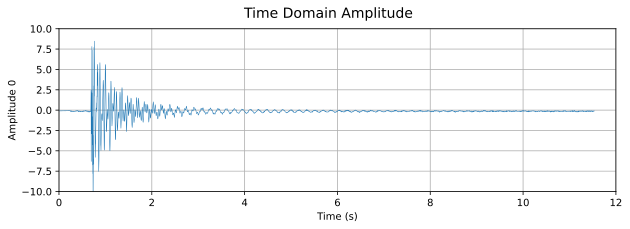

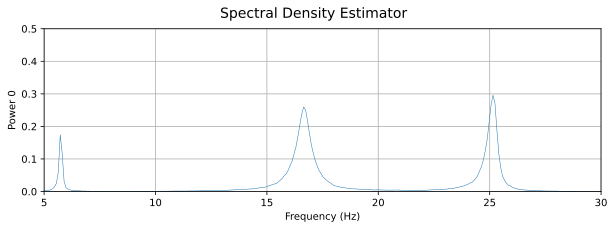

In [26]:
med = Acelr(0, arq="med22ok")
med21 = MRPy(med[0], Td=med.Td)

med21.plot_time(fig=3, figsize=(10,3), axis_t=[0,12,-10,10])
med21.plot_freq(fig=4, figsize=(10,3), axis_f=[5,30,0,0.5])

No primeiro gráfico, de acelerações, é nítida a presença de mais de uma frequência no sinal. Através do periodograma são então observadas as três frequências atuantes no sinal, de aproximadamente 6, 17 e 25 Hz. Ampliando a região dos picos tem-se:

[[<matplotlib.lines.Line2D at 0x28cf5b733d0>]]

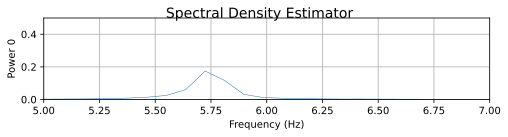

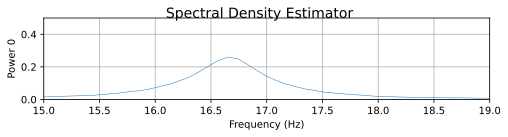

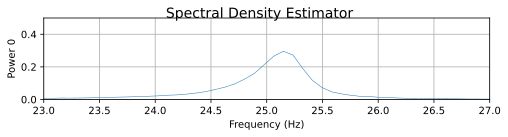

In [27]:
med21.plot_freq(fig=4, figsize=(8,1.5), axis_f=[5,7,0,0.5])
med21.plot_freq(fig=5, figsize=(8,1.5), axis_f=[15,19,0,0.5])
med21.plot_freq(fig=6, figsize=(8,1.5), axis_f=[23,27,0,0.5])

Observa-se que a primeira frequência medida é de cerca de $5.7 Hz$, a segunda de $16.7 Hz$ e a terceira de $25.2 Hz$. Comparando essas às obtidas pela análise de propagação de erro observa-se que todas estão no intervalo de até 1 desvio padrão ($1\times\sigma$). Observa-se ainda que a segunda frequência medida é a mais próxima da frequência teórica, enquanto a primeira medida é menor, e a terceira é maior.

Aplicando sobre as frequências estimadas o fator de escala de frequências $\lambda_f$ tem-se:

In [28]:
j2l.print("""Demais frequências da estrutura obtidas a partir do modelo reduzido: 
$$f_2 = {:.2f} Hz$$
$$f_3 = {:.2f} Hz$$
""".format(16.7/escalas.loc['f', 'λ'], 25.2/escalas.loc['f', 'λ']))

Demais frequências da estrutura obtidas a partir do modelo reduzido: 
$$f_2 = 3.03 Hz$$
$$f_3 = 4.58 Hz$$

# Considerações finais




Para fins de comparação as frequências teóricas de vibração da estrutura real podem ser determinadas através da função programada anteriormente:

In [29]:
est_fk = freqs(est_EI*2, est_L, est_L, est_L, M_pavcob, M_pavtipo, M_pavtipo) 
# EI*2 pq código considera 2 pilares e estrutura tem 4 

j2l.print("""Frequências naturais teóricas de vibração da estrutura:

- $f_1 = {:.2f} Hz$

- $f_2 = {:.2f} Hz$

- $f_3 = {:.2f} Hz$""".format(*est_fk))

Frequências naturais teóricas de vibração da estrutura:

- $f_1 = 1.09 Hz$

- $f_2 = 3.02 Hz$

- $f_3 = 4.31 Hz$

Observa-se que as frequências teóricas da estrutura real são condizentes com as frequências do modelo reduzido escaladas por $\lambda_f$, validando seu projeto. Ao comparar as frequências esperadas, obtidas da análise de propagação de erro, às medidas experimentalmente, são observados resultados satisfatórios, com erros inferiores à 1 desvio padrão. 

Conclui-se então que o uso de modelos reduzidos e de equipamentos de baixo custo, como o Arduino Uno e o acelerômetro MPU6050, são ferramentas poderosas para realização de ensaios experimentais. 

# Referencias

Rocha, M. M. **PEC00144 - Experimental Methods in Civil Engineering**, 2021. Disponível em: <https://github.com/mmaiarocha/PEC00144>. 